In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geojson
from patchify import patchify
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from typing import Union
import random
import os
import glob

OPENSLIDE_PATH  = r'C:/openslide/openslide-win64/bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [3]:
patches_path = './patches/'

In [4]:
glob.glob(patches_path + '**/**')

['./patches/BRACS_745/Benign-sure-5',
 './patches/BRACS_745/Pathological-benign-9',
 './patches/BRACS_745/Pathological-benign-17',
 './patches/BRACS_745/Pathological-benign-16',
 './patches/BRACS_745/Benign-sure-4',
 './patches/BRACS_745/Benign-sure-20',
 './patches/BRACS_745/Benign-sure-2',
 './patches/BRACS_745/Pathological-benign-10',
 './patches/BRACS_745/Benign-sure-19',
 './patches/BRACS_745/Benign-sure-11',
 './patches/BRACS_745/Benign-sure-7',
 './patches/BRACS_745/Benign-sure-13',
 './patches/BRACS_745/Benign-sure-1',
 './patches/BRACS_745/Pathological-benign-18',
 './patches/BRACS_745/Pathological-benign-15',
 './patches/BRACS_745/Pathological-benign-14',
 './patches/BRACS_745/Benign-sure-8',
 './patches/BRACS_745/Benign-sure-6',
 './patches/BRACS_745/Benign-sure-3',
 './patches/BRACS_745/Benign-sure-21',
 './patches/BRACS_745/Pathological-benign-0',
 './patches/BRACS_745/Benign-sure-12',
 './patches/BRACS_1486/FEA-sure-7',
 './patches/BRACS_1486/Pathological-benign-9',
 './p

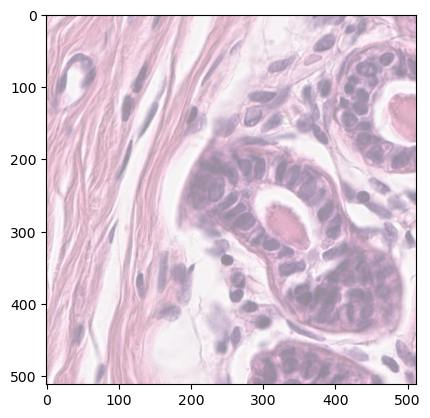

In [5]:
for roi in glob.glob(patches_path + '**/**'):
    img_paths = glob.glob(roi + '/patch/*.png')
    mask_paths = glob.glob(roi + '/mask/*.png')
    img = cv2.imread(img_paths[0], cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_paths[0], cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGRA2RGB)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.show()
        

    break

RGB image shape: (512, 512, 3)
RGB example pixel values: [ 85  57 110]
CIELAB image shape: (512, 512, 3)
CIELAB example pixel values:[ 75 152 102]
Black and white image shape: (512, 512)
Black and white example pixel values: 71


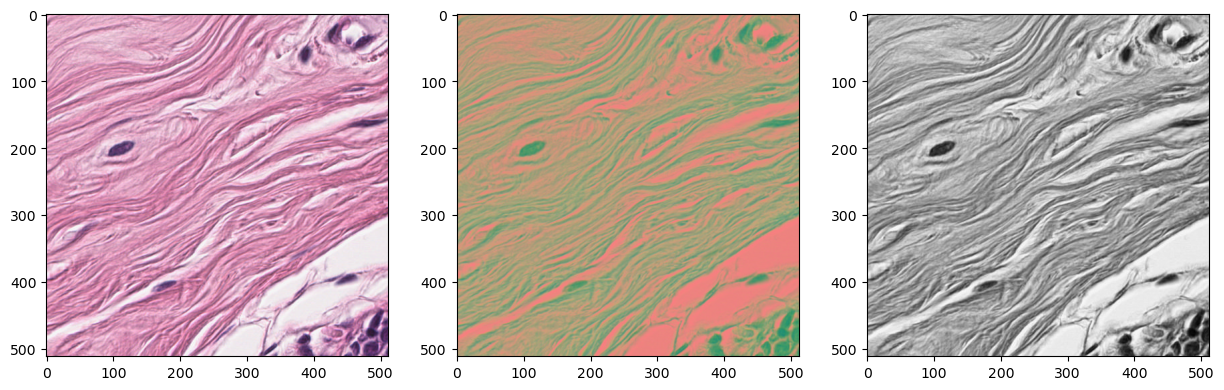

In [6]:
test_img = cv2.imread("./patches/BRACS_745/Pathological-benign-15/patch/0_0.png", cv2.IMREAD_UNCHANGED)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGRA2RGB)
cielab_test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2LAB)
bw_test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(1, 3, figsize=(15, 15))


print(f"RGB image shape: {test_img.shape}")
print(f"RGB example pixel values: {test_img[200, 100, :]}")

print(f"CIELAB image shape: {cielab_test_img.shape}")
print(f"CIELAB example pixel values:{cielab_test_img[200, 100, :]}")

print(f"Black and white image shape: {bw_test_img.shape}")
print(f"Black and white example pixel values: {bw_test_img[200, 100]}")

ax[0].imshow(test_img)
ax[1].imshow(cielab_test_img)
ax[2].imshow(bw_test_img, cmap='gray')
plt.show()

In [7]:
def cielab_intensify_to_rgb(img: Union[np.ndarray, torch.Tensor], rate: float):
    cie_img = np.array(img)
    if isinstance(img, torch.Tensor):
        cie_img = cie_img * 255
    cie_img[:, :, 0][cie_img[:, :, 0] > 127] = np.clip(cie_img[:, :, 0][cie_img[:, :, 0] > 127] * (1 + rate), 0, 255)
    cie_img[:, :, 0][cie_img[:, :, 0] < 127] = np.clip(cie_img[:, :, 0][cie_img[:, :, 0] < 127] * (1 - rate), 0, 255)

    cie_img[:, :, 1][cie_img[:, :, 1] > 127] = np.clip(cie_img[:, :, 1][cie_img[:, :, 1] > 127] * (1 - rate), 0, 255)
    cie_img[:, :, 1][cie_img[:, :, 1] < 127] = np.clip(cie_img[:, :, 1][cie_img[:, :, 1] < 127] * (1 + rate), 0, 255)

    cie_img[:, :, 2][cie_img[:, :, 2] > 127] = np.clip(cie_img[:, :, 2][cie_img[:, :, 2] > 127] * (1 - rate), 0, 255)
    cie_img[:, :, 2][cie_img[:, :, 2] < 127] = np.clip(cie_img[:, :, 2][cie_img[:, :, 2] < 127] * (1 + rate), 0, 255)
    
    cie_img = cie_img.astype(np.uint8)
    rgb_img = cv2.cvtColor(cie_img, cv2.COLOR_LAB2RGB)
    return rgb_img

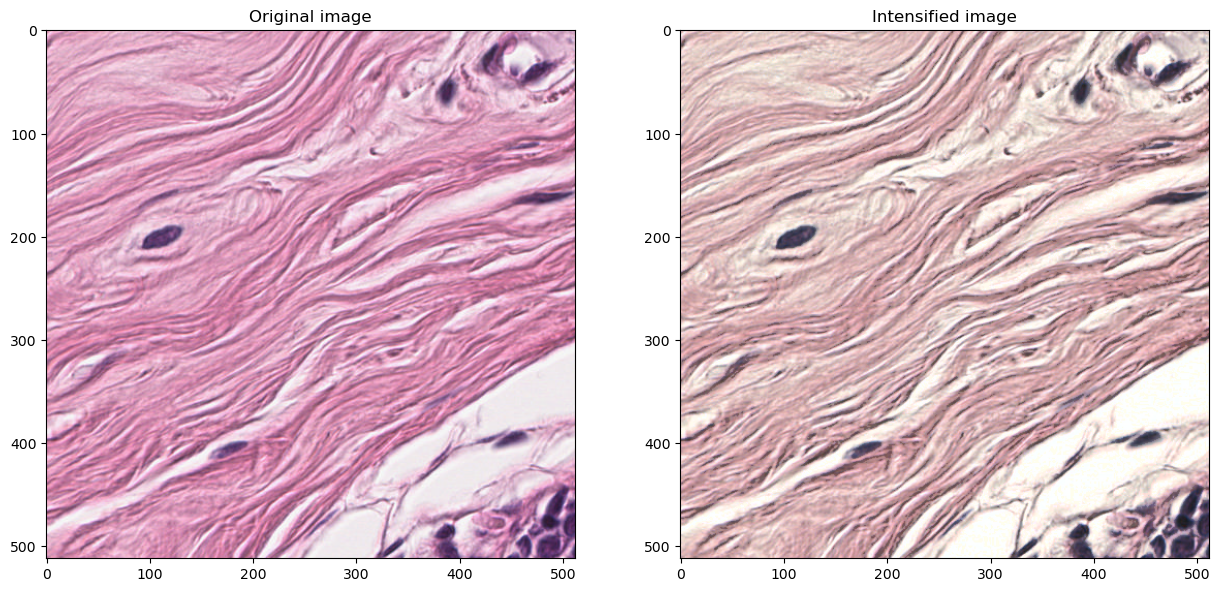

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(test_img)
ax[0].set_title("Original image")
ax[1].imshow(cielab_intensify_to_rgb(cielab_test_img, 0.1))
ax[1].set_title("Intensified image")
plt.show()

In [53]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [122]:
class PatchDataset(Dataset):
    def __init__(self, imgPaths, maskPaths, mode: str, transform=None, seed=0):
        self.imgs = imgPaths
        self.masks = maskPaths
        self.transform = transform
        self.mode = mode
        self.seed = seed
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # print(f"image path: {img_path}, mask path: {mask_path}")
        
        if self.mode == 'RGB':
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        elif self.mode == 'CIELAB':
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif self.mode == 'BW':
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # set seed so that the same transformation is applied to image and mask
        if self.transform:
            # transform the image
            random.seed(self.seed)
            transformed = self.transform(image=img, mask=mask)
            img, mask = transformed["image"].float()/255.0, transformed["mask"].long()/255.0
            self.seed += 1
            
        return img, mask

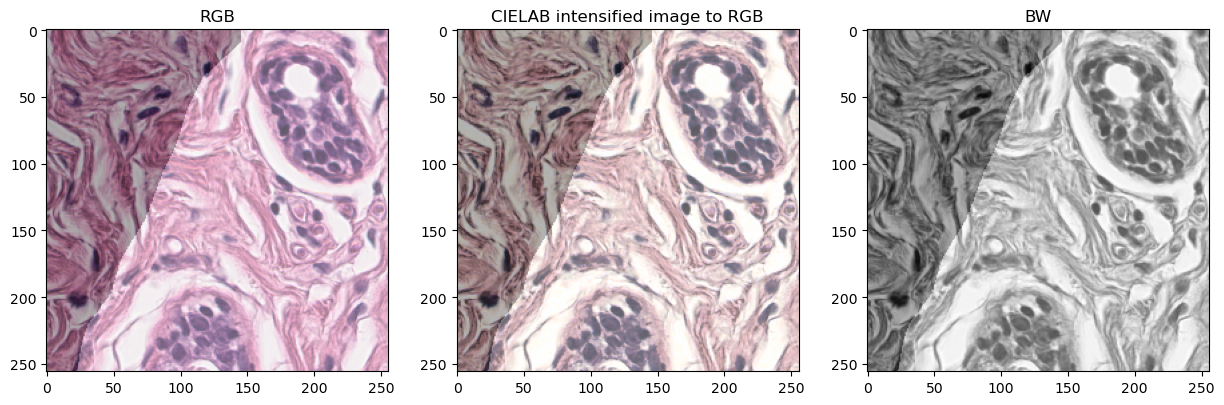

In [123]:
sample_patches_path = "./patches/BRACS_745/Pathological-benign-0/patch/"
sample_masks_path = "./patches/BRACS_745/Pathological-benign-0/mask/"

patch_rgb_dataset = PatchDataset(
    imgPaths=glob.glob(sample_patches_path + '*.png'),
    maskPaths=glob.glob(sample_masks_path + '*.png'),
    mode='RGB',
    transform=train_transform,
    seed=0
)

patch_cielab_dataset = PatchDataset(
    imgPaths=glob.glob(sample_patches_path + '*.png'),
    maskPaths=glob.glob(sample_masks_path + '*.png'),
    mode='CIELAB',
    transform=train_transform,
    seed=0
)

patch_bw_dataset = PatchDataset(
    imgPaths=glob.glob(sample_patches_path + '*.png'),
    maskPaths=glob.glob(sample_masks_path + '*.png'),
    mode='BW',
    transform=train_transform,
    seed=0
)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].title.set_text('RGB')
rgb_img, rgb_mask = patch_rgb_dataset[2]
ax[0].imshow(rgb_img.permute(1, 2, 0))
ax[0].imshow(rgb_mask, alpha=0.3, cmap='gray')

ax[1].title.set_text('CIELAB intensified image to RGB')
cielab_img, cielab_mask = patch_cielab_dataset[2]
ax[1].imshow(cielab_intensify_to_rgb(cielab_img.permute(1, 2, 0), 0.1))
ax[1].imshow(cielab_mask, alpha=0.3, cmap='gray')

ax[2].title.set_text('BW')
bw_img, bw_mask = patch_bw_dataset[2]
ax[2].imshow(bw_img.permute(1, 2, 0), cmap='gray')
ax[2].imshow(bw_mask, alpha=0.3, cmap='gray')

plt.show()